In [12]:
import h5py as h5
import numpy as np

from glob import glob
from tqdm import tqdm

from scipy.interpolate import CubicSpline, interp1d
from scipy.optimize import ridder

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, to_rgba, to_rgb
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D

import sys
import os

sys.path.append("../../ASTERIA/python/")
os.environ["ASTERIA"] = "/Users/jlazar/research/ASTERIA"

sys.path.append("../")
from sne_bsm import units, deserialize

plt.style.use("paper.mplstyle")

In [55]:
SM_SERIALIZE_FILE = "../resources/serialized_fluxes/serialized_sm_flux.h5"
BSM_SERIALIZE_FILE = "../resources/serialized_fluxes/serialized_majoron_fluxes.h5"

TS_FILE = "../resources/ts_time_series.h5"
TRIALS_FILE = "../resources/majoron_trials.h5"

MODEL1 = "dphi-dEdt-0d1MeV-gn9dot25-100s-nf"
MODEL2 = "dphi-dEdt-150MeV-gn11dot6-100s-nf"

MODELS = [
    MODEL1,
    MODEL2,
]

COLORS = [
    "mediumturquoise", # MODEL1
    "dodgerblue", # MODEL2
    "hotpink",
    # "red", # SM
]

LABELS = [
    r"$m_{\phi}=0.1~\mathrm{MeV}$",
    r"$m_{\phi}=150~\mathrm{MeV}$",
]

RESULTS_FILE = "../resources/majoron_results.h5"

# Flux plot

## Deserialize the fluxes

In [31]:
with h5.File(SM_SERIALIZE_FILE, "r") as h5f:
    sm_flux = deserialize(h5f["sm_flux_0"])

bsm_fluxes = []

for model in tqdm(MODELS):
    with h5.File(BSM_SERIALIZE_FILE, "r") as h5f:
        flux = deserialize(h5f[f"{model}_0"])
    bsm_fluxes.append(flux)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:24<00:00, 12.29s/it]


## Make the plot

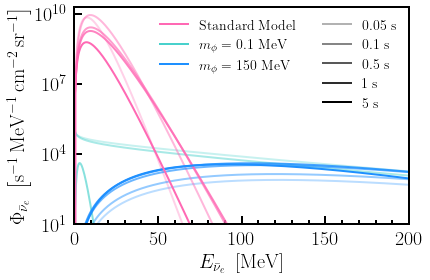

In [32]:
es = np.linspace(0, 200, 400) * units.MeV
ts = np.array([0.05, 0.1, 0.5, 1, 5]) * units["second"]

alphamin = 0.3
alphamax = 1.0

handles = [
    Line2D([], [], color=COLORS[-1], label=r"Standard Model"),
    Line2D([], [], color=COLORS[0], label=r"$m_{\phi}=0.1~\mathrm{MeV}$"),
    # Line2D([], [], color=COLORS[1], label=r"$m_{\phi}=10~\mathrm{MeV}$"),
    Line2D([], [], color=COLORS[1], label=r"$m_{\phi}=150~\mathrm{MeV}$"),
    Line2D([], [], alpha=0.0),
    Line2D([], [], alpha=0.0),
    Line2D([], [], color="k", alpha=0/4*(alphamax - alphamin) + alphamin, label=r"$\mathrm{0.05}~\mathrm{s}$"),
    Line2D([], [], color="k", alpha=1/4*(alphamax - alphamin) + alphamin, label=r"$\mathrm{0.1}~\mathrm{s}$"),
    Line2D([], [], color="k", alpha=2/4*(alphamax - alphamin) + alphamin, label=r"$\mathrm{0.5}~\mathrm{s}$"),
    Line2D([], [], color="k", alpha=3/4*(alphamax - alphamin) + alphamin, label=r"$\mathrm{1}~\mathrm{s}$"),
    Line2D([], [], color="k", alpha=4/4*(alphamax - alphamin) + alphamin, label=r"$\mathrm{5}~\mathrm{s}$"),
]


for idx, t in enumerate(ts):
    alpha = idx / (len(ts)-1) * (alphamax - alphamin) + alphamin
    for color, flux in zip(COLORS, bsm_fluxes):
        plt.plot(
            es / units.MeV,
            flux.get_flux(t, es, 1) * units.second * units.MeV,
            color=to_rgb(color) + (alpha,)
        )
    
    # Only plot the SM flux for the first 8 seconds
    if t > 8 * units.second:
        continue
    
    plt.plot(
        es / units.MeV,
        sm_flux.get_flux(t, es, 1) * units.second * units.MeV,
        color=to_rgb(COLORS[-1]) + (alpha,)   
    )

       
plt.ylabel(
    r"$\Phi_{\bar{\nu}_{e}}~\left[\mathrm{s}^{-1}\,\mathrm{MeV}^{-1}\,\mathrm{cm}^{-2}\,\mathrm{sr}^{-1}\right]$",
    # r"$\frac{\mathrm{d}N_{\bar{\nu}_{e}}}{\mathrm{d}t\mathrm{d}E}~\left[\mathrm{s}^{-1}\,\mathrm{MeV}^{-1}\,\mathrm{cm}^{-2}\right]$",
    fontsize=20
)
plt.xlabel(
    r"$E_{\bar{\nu}_{e}}~\left[\mathrm{MeV}\right]$"
)
plt.ylim(1e1, 2e10)
plt.xlim(es.min() / units.MeV, es.max() / units.MeV)
plt.semilogy()
plt.legend(
    handles=handles,
    ncol=2,
    fontsize=14,
    framealpha=0.0,
    loc=1,
    # bbox_to_anchor=(1, 1.075)
)
plt.savefig("../figures/majoran_fluxes.pdf")
plt.show()

# Hits and likelihood plot

In [33]:
# dt = 0.01 * units.second
# sm_ts, sm_hits = sm_flux.get_hits(
#     tmax=100 * units["second"],
#     model_file="paper_plots.txt",
#     dt=dt
# )

In [34]:
with h5.File(TRIALS_FILE) as h5f:
    print(h5f.keys())

<KeysViewHDF5 ['results_29', 'results_30', 'results_67', 'results_72']>


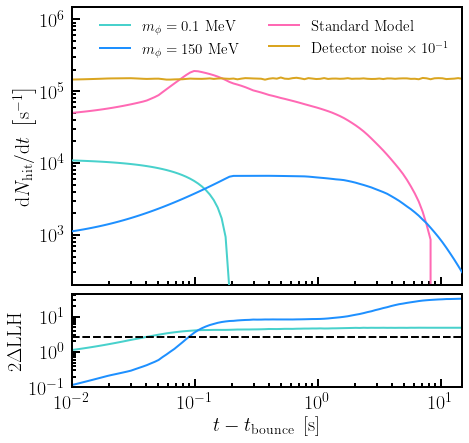

In [37]:
fig, axs = plt.subplots(
    figsize=(7, 7),
    nrows=2,
    gridspec_kw={"hspace": 0.05, "height_ratios": (3,1)}
)

logspace_t = np.logspace(-2, np.log10(14.9), 100)


ax0, ax1 = axs[0], axs[1]
for idx, model in enumerate(MODELS):
    color = COLORS[idx]
    
    with h5.File(TS_FILE) as h5f:
        for k, v in h5f.items():
            if v.attrs["bsm_name"]!=f"{model}_0":
                continue
            times = v["times"][:]
            dt = np.diff(times)[0]
            mask = times <= 15
            times = times[mask]
            hits = v["bsm_hits"][mask]
            test_stats = np.median(np.cumsum(v["test_statistic_series"][mask, :], axis=0), axis=1)
            
            i = interp1d(times, test_stats)
            line = ax1.plot(logspace_t, i(logspace_t), color=color)
#             line = ax1.plot(times, test_stats, color=color)
            
            i = interp1d(times, hits / dt)
            
            ax0.plot(logspace_t, i(logspace_t), color=color, label=LABELS[idx], zorder=10)
#             ax0.plot(times, hits / dt, color=color, label=LABELS[idx], zorder=10)
            
            if idx==0:
                continue
            
            i = interp1d(times, v["sm_hits"][mask] / dt)
            ax0.plot(logspace_t, i(logspace_t), color=COLORS[-1], label="Standard Model")
            
            i = interp1d(times, 0.1 * v["bg_hits"][mask] / dt)
            ax0.plot(logspace_t, i(logspace_t), color="goldenrod", label=r"$\mathrm{Detector~noise} \times 10^{-1}$")
            
    with h5.File(TRIALS_FILE) as h5f:
        for k, v in h5f.items():
            if v.attrs["bsm_name"]!=f"{model}_0":
                continue
            bg95 = np.quantile(v["background/ts"], 0.95)
            ax1.axhline(bg95, color="k", lw=2, ls="--")
#             ax1.axhline(bg95, color=line[0].get_color(), lw=2, ls="--")

ax0.legend(loc=1, fontsize=15, ncol=2, framealpha=0.0)
ax0.loglog()
ax0.set_ylim(200, 1.5e6)
ax0.set_ylabel(r"$\mathrm{d}N_{\mathrm{hit}}/\mathrm{d}t~\left[\mathrm{s}^{-1}\right]$")

ax1.set_xlabel(r"$t - t_{\mathrm{bounce}}~\left[\mathrm{s}\right]$")
ax1.set_ylabel(r"$2\Delta \mathrm{LLH}$")
ax1.loglog()
ax1.set_ylim(0.1, None)

for ax in axs:
    ax.set_xlim(1e-2, 15)
    
ax0.set_xticklabels([])

plt.show()

# Majoran sensitity plot

## Interpolate the CSVs so that we can fill between

## Make the plot

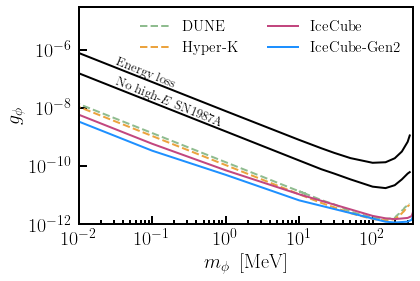

In [13]:
energy_loss_bound = np.load("data/energy_loss_bound.npy")
no_high_e_bound = np.load("data/no_high_e_bound.npy")

with h5.File("./data/previous_results.h5") as h5f:
    a = h5f["dune_sensitivies"]["masses"][:]
    b = h5f["dune_sensitivies"]["couplings"][:]
    dune_sensitivies = np.array([a,b])
    
    a = h5f["hk_sensitivies"]["masses"][:]
    b = h5f["hk_sensitivies"]["couplings"][:]
    hk_sensitivies = np.array([a,b])

with h5.File(RESULTS_FILE) as h5f:
    gen1_masses = h5f["majoron_sensitivities"]["masses"][:]
    gen1_couplings = h5f["majoron_sensitivities"]["couplings"][:]
    gen2_masses = h5f["majoron_sensitivities_gen2"]["masses"][:]
    gen2_couplings = h5f["majoron_sensitivities_gen2"]["couplings"][:]
    
    
fig, ax = plt.subplots()

ax.plot(energy_loss_bound[:, 0], energy_loss_bound[:, 1], color="k")
ax.plot(no_high_e_bound[:, 0], no_high_e_bound[:, 1], color="k")

# ax.fill_between(
#     energy_loss_bound[:, 0],
#     energy_loss_bound[:, 1],
#     1,
#     facecolor=to_rgb("grey") + (0.3,),
#     edgecolor="k" 
# )

# ax.fill_between(
#     no_high_e_bound[:, 0],
#     no_high_e_bound[:, 1],
#     energy_loss_bound[:, 1],
#     facecolor=to_rgb("grey") + (0.3,),
#     edgecolor="k"
# )

ax.plot(dune_sensitivies[0], dune_sensitivies[1] / dune_sensitivies[0], label="DUNE", color="darkseagreen", ls="--")
ax.plot(hk_sensitivies[0], hk_sensitivies[1] / hk_sensitivies[0], label="Hyper-K", color="#eba33e", ls="--")
# ax.plot(gen1_masses, gen1_couplings, label="IceCube (This work)", color="#c2477f")
# ax.plot(gen2_masses, gen2_couplings, label="IceCube-Gen2 (This work)", color="dodgerblue")
ax.plot(gen1_masses, gen1_couplings, label="IceCube", color="#c2477f")
ax.plot(gen2_masses, gen2_couplings, label="IceCube-Gen2", color="dodgerblue")

ax.text(3e-2, 5e-8, "Energy loss", rotation=-22, fontsize=13)
ax.text(3e-2, 2.2e-9, r"No high-$E$ SN1987A", rotation=-22, fontsize=13)

ax.set_xlabel(r"$m_{\phi}~\left[\mathrm{MeV}\right]$")
ax.set_ylabel(r"$g_{\phi}$")

ax.legend(fontsize=15, ncol=2, framealpha=0)

ax.set_xlim(1e-2, 360)
ax.set_ylim(1e-12, 3e-5)

ax.loglog()

plt.savefig("../figures/majoran_sensitivity.pdf")
plt.show()

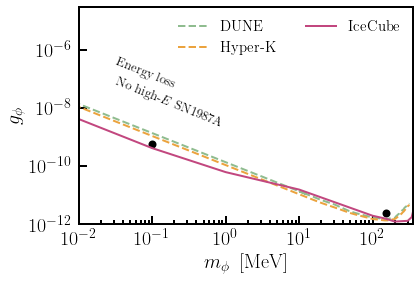

In [59]:
# energy_loss_bound = np.load("data/energy_loss_bound.npy")
# no_high_e_bound = np.load("data/no_high_e_bound.npy")

with h5.File("./data/previous_results.h5") as h5f:
    a = h5f["dune_sensitivies"]["masses"][:]
    b = h5f["dune_sensitivies"]["couplings"][:]
    dune_sensitivies = np.array([a,b])
    
    a = h5f["hk_sensitivies"]["masses"][:]
    b = h5f["hk_sensitivies"]["couplings"][:]
    hk_sensitivies = np.array([a,b])

with h5.File(RESULTS_FILE) as h5f:
    gen1_masses = h5f["majoron_sensitivities"]["masses"][:]
    gen1_couplings = h5f["majoron_sensitivities"]["exclusions"][:]
#     gen2_masses = h5f["majoron_sensitivities_gen2"]["masses"][:]
#     gen2_couplings = h5f["majoron_sensitivities_gen2"]["couplings"][:]

cps = [10 ** float(x.split("-")[3].replace("dot", ".").replace("d", ".")[1:].replace("n", "-")) for x in MODELS]
mss = [float(x.split("-")[2].replace("MeV", "").replace("d", ".")) for x in MODELS]
    
fig, ax = plt.subplots()

# ax.plot(energy_loss_bound[:, 0], energy_loss_bound[:, 1], color="k")
# ax.plot(no_high_e_bound[:, 0], no_high_e_bound[:, 1], color="k")

ax.scatter(mss, cps, color="k")

ax.plot(dune_sensitivies[0], dune_sensitivies[1] / dune_sensitivies[0], label="DUNE", color="darkseagreen", ls="--")
ax.plot(hk_sensitivies[0], hk_sensitivies[1] / hk_sensitivies[0], label="Hyper-K", color="#eba33e", ls="--")
# ax.plot(gen1_masses, gen1_couplings, label="IceCube (This work)", color="#c2477f")
# ax.plot(gen2_masses, gen2_couplings, label="IceCube-Gen2 (This work)", color="dodgerblue")
ax.plot(gen1_masses, gen1_couplings, label="IceCube", color="#c2477f")
# ax.plot(gen2_masses, gen2_couplings, label="IceCube-Gen2", color="dodgerblue")

ax.text(3e-2, 5e-8, "Energy loss", rotation=-22, fontsize=13)
ax.text(3e-2, 2.2e-9, r"No high-$E$ SN1987A", rotation=-22, fontsize=13)

ax.set_xlabel(r"$m_{\phi}~\left[\mathrm{MeV}\right]$")
ax.set_ylabel(r"$g_{\phi}$")

ax.legend(fontsize=15, ncol=2, framealpha=0)

ax.set_xlim(1e-2, 360)
ax.set_ylim(1e-12, 3e-5)

ax.loglog()

plt.savefig("../figures/majoran_sensitivity.pdf")
plt.show()

# Magnetic moment sensitivity plot

## Load up the exclusion data

In [14]:
# These are the limits from ArXiv:2302.10965
lb1 = np.genfromtxt("./data/magnetic_moment_lower_exc_1.csv", delimiter=",")
ub1 = np.genfromtxt("./data/magnetic_moment_upper_exc_1.csv", delimiter=",")
lb2 = np.genfromtxt("./data/magnetic_moment_upper_exc_2.csv", delimiter=",")

lb1_interp = interp1d(np.log(lb1[:, 0]), np.log(lb1[:, 1]), fill_value="extrapolate")
lb2_interp = interp1d(np.log(lb2[:, 0]), np.log(lb2[:, 1]), fill_value="extrapolate")
ub1_interp = interp1d(np.log(ub1[:, 0]), np.log(ub1[:, 1]), fill_value="extrapolate")

# These are the limits from 2402.#####
new_excl = np.genfromtxt("/Users/jlazar/Downloads/new_exclusion.csv", delimiter=",")
s = np.sign(np.diff(new_excl[:, 0]))
splitat = np.argwhere([x!=y for x, y in zip(s, s[1:])])[0][0]

new_excl_interp0 = interp1d(
    np.log(new_excl[:splitat, 0]),
    np.log(new_excl[:splitat, 1] / 1e3),
    fill_value="extrapolate"
)
new_excl_interp1 = interp1d(
    np.log(new_excl[splitat:, 0]),
    np.log(new_excl[splitat:, 1] / 1e3),
    fill_value="extrapolate"
)

# f = lambda lx: np.exp(new_excl_interp0(lx)) - np.exp(ub1_interp(lx))

# m0 = np.exp(ridder(f, np.log(20), np.log(300)))

masses1 = np.logspace(np.log10(lb1[:, 0].min()), np.log10(min(lb1[:, 0].max(), ub1[:, 0].max())))
masses2 = np.logspace(np.log10(lb1[:, 0].min()), np.log10(lb2[:, 0].max()))
masses3 = np.logspace(
    np.log10(5),
    np.log10(new_excl[:, 0].max()),
)

xs = np.hstack((lb1[:, 0], ub1[::-1, 0], lb2[:, 0]))
ys = np.hstack((lb1[:, 1], ub1[::-1, 1], lb2[:, 1]))

dune_sensitivies = np.genfromtxt("./data/dune_magnetic_moment_sens.csv", delimiter=",")
hk_sensitivies = np.genfromtxt("./data/hyper_magnetic_moment_sens.csv", delimiter=",")

dune_spl = interp1d(np.log(dune_sensitivies[:, 0]), np.log(dune_sensitivies[:, 1]))
hk_spl = interp1d(np.log(hk_sensitivies[:, 0]), np.log(hk_sensitivies[:, 1]))

dune_f = lambda lx: np.exp(dune_spl(lx)) - np.exp(ub1_interp(lx))
hk_f = lambda lx: np.exp(hk_spl(lx)) - np.exp(ub1_interp(lx))

with h5.File("./data/new_results.h5") as h5f:
    gen1_masses = h5f["magnetic_moment_sensitivities"]["masses"][:]
    gen1_couplings = h5f["magnetic_moment_sensitivities"]["couplings"][:]
    gen2_masses = h5f["magnetic_moment_sensitivities_gen2"]["masses"][:]
    gen2_couplings = h5f["magnetic_moment_sensitivities_gen2"]["couplings"][:]
    
# ic_spl = interp1d(np.log(masses), np.log(couplings))
# ic_f = lambda lx: np.exp(ic_spl(lx)) - np.exp(ub1_interp(lx))

# hk_m = np.exp(ridder(hk_f, np.log(100), np.log(200)))
# ic_m = np.exp(ridder(ic_f, np.log(100), np.log(200)))
# dune_m = np.exp(ridder(dune_f, np.log(100), np.log(200)))
# print(hk_m, ic_m, dune_m)

## Make the plot

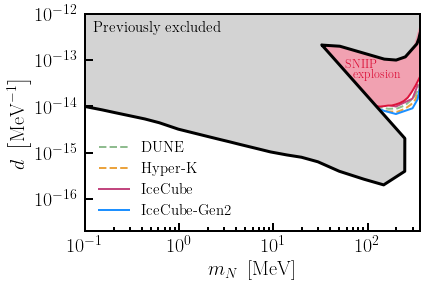

In [15]:
# Option 2
fig, ax = plt.subplots()

ax.fill_between(
    masses3,
    np.exp(new_excl_interp0(np.log(masses3))),
    np.exp(new_excl_interp1(np.log(masses3))),
    # edgecolor="dodgerblue",
    facecolor="white"
)

ax.fill_between(
    masses3,
    np.exp(new_excl_interp0(np.log(masses3))),
    np.exp(new_excl_interp1(np.log(masses3))),
    edgecolor="crimson",
    facecolor=to_rgb("crimson") + (0.4,)
)


ax.fill_between(
    masses1,
    np.exp(lb1_interp(np.log(masses1))),
    np.exp(ub1_interp(np.log(masses1))),
    facecolor="lightgray",
)

ax.fill_between(
    masses2,
    np.exp(lb2_interp(np.log(masses2))), 
    1,
    facecolor="lightgray",
)
ax.plot(xs, ys, lw=3, color="k")

# ax.plot(new_excl[:splitat, 0], new_excl[:splitat, 1]/1e3)
# ax.plot(new_excl[splitat:, 0], new_excl[splitat:, 1]/1e3)

ax.plot(dune_sensitivies[:, 0], dune_sensitivies[:, 1], label="DUNE", color="darkseagreen", zorder=0, ls="--")
ax.plot(hk_sensitivies[:, 0], hk_sensitivies[:, 1], label="Hyper-K", color="#eba33e", zorder=0, ls="--")
ax.plot(gen1_masses, gen1_couplings, label="IceCube", color="#c2477f", zorder=0)
ax.plot(gen2_masses, gen2_couplings, label="IceCube-Gen2", color="dodgerblue", zorder=0)

ax.set_xlabel(r"$m_{N}~\left[\mathrm{MeV}\right]$")
ax.set_ylabel(r"$d~\left[\mathrm{MeV}^{-1}\right]$")

ax.legend(fontsize=15, ncol=1, framealpha=0, loc=3)

ax.set_xlim(0.1, 360)
ax.set_ylim(2e-17, 1e-12)

ax.text(1.2e-1, 4e-13, "Previously excluded", fontsize=15, zorder=11)
ax.text(58, 7e-14, "SNIIP ", fontsize=12, zorder=14, color="crimson")
ax.text(70, 4e-14, "explosion", fontsize=12, zorder=14, color="crimson")

ax.loglog()

ax.set_yticks([1e-12, 1e-13, 1e-14, 1e-15, 1e-16])

# plt.savefig("../figures/magnetic_moment_sensitivity_no_lines.pdf")
plt.savefig("../figures/magnetic_moment_sensitivity.pdf")
plt.show()